In [35]:
#%% [markdown]
# Zadanie 2.3 – Optymalizacja layoutu farmy wiatrowej (IEA-37)
# Cel: porównać wpływ ograniczeń i sterowników na AEP

import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import os

from topfarm import TopFarmProblem
from topfarm.easy_drivers import EasyScipyOptimizeDriver
from topfarm.plotting import XYPlotComp, NoPlot
from topfarm.constraint_components.boundary import XYBoundaryConstraint
from topfarm.constraint_components.spacing import SpacingConstraint

from topfarm.examples.iea37 import get_iea37_initial, get_iea37_constraints

from py_wake.examples.data.iea37 import IEA37_WindTurbines, IEA37Site
from py_wake.deficit_models.gaussian import IEA37SimpleBastankhahGaussian

from topfarm.cost_models.py_wake_wrapper import PyWakeAEPCostModelComponent

# Tworzymy foldery na wyniki od razu
os.makedirs("results/figures", exist_ok=True)
os.makedirs("results/tables", exist_ok=True)

print("Importy OK")

Importy OK


/usr/local/python/3.12.1/lib/python3.12/site-packages/py_wake/deficit_models/gaussian.py:279: UserWarning: The IEA37SimpleBastankhahGaussian model is not representative of the setup used in the literature. For this, use py_wake.literature.iea37_case_study1.IEA37CaseStudy1 instead
  DeprecatedModel.__init__(self, 'py_wake.literature.iea37_case_study1.IEA37CaseStudy1')


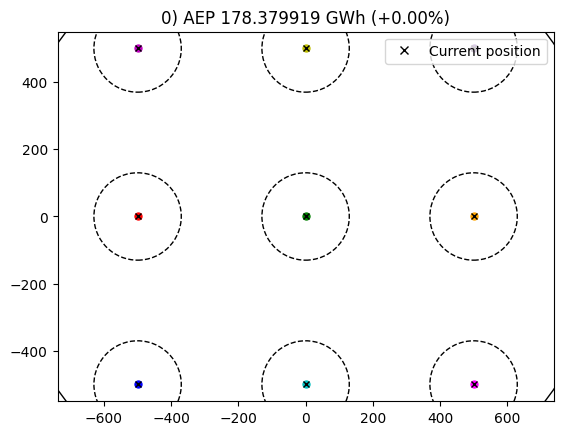

KeyError: 'AEP'

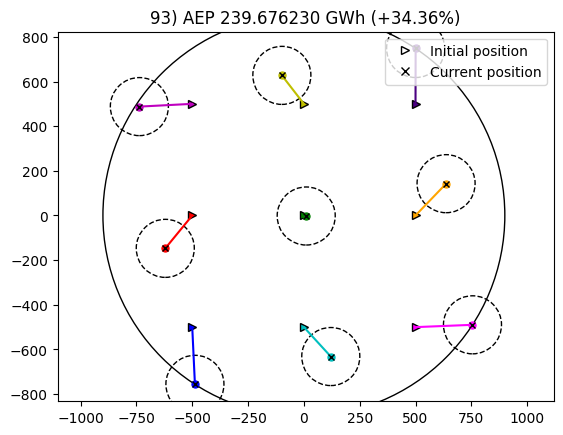

In [37]:
#%% [markdown]
## Sprint 1 – Bazowa optymalizacja IEA-37 (9 turbin)

n_wt = 9
x_init, y_init = get_iea37_initial(n_wt).T

D = 130.0               # założona średnica wirnika [m]
wd = np.linspace(0, 360, 16, endpoint=False)   # 16 kierunków

site = IEA37Site(n_wt)
wt = IEA37_WindTurbines()
wake_model = IEA37SimpleBastankhahGaussian(site, wt)

cost_comp = PyWakeAEPCostModelComponent(
    windFarmModel = wake_model,
    n_wt = n_wt,
    wd = wd
)

driver = EasyScipyOptimizeDriver(
    optimizer = 'SLSQP',
    maxiter = 150,
    tol = 1e-4,
    disp = False
)

tf = TopFarmProblem(
    design_vars = {'x': x_init, 'y': y_init},
    cost_comp = cost_comp,
    constraints = get_iea37_constraints(n_wt),
    driver = driver,
    plot_comp = XYPlotComp()        # animacja – widać co się dzieje
)

t0 = time.time()
tf.evaluate()
AEP_init = tf['AEP'][0]             # ← DUŻE AEP

_, state, _ = tf.optimize()
AEP_opt = state['AEP'][0]           # ← DUŻE AEP

czas = time.time() - t0

print(f"Czas: {czas:.1f} s")
print(f"AEP start:  {AEP_init:.2f} GWh")
print(f"AEP po:     {AEP_opt:.2f} GWh")
print(f"Poprawa:    {(AEP_opt / AEP_init - 1) * 100:.1f} %")

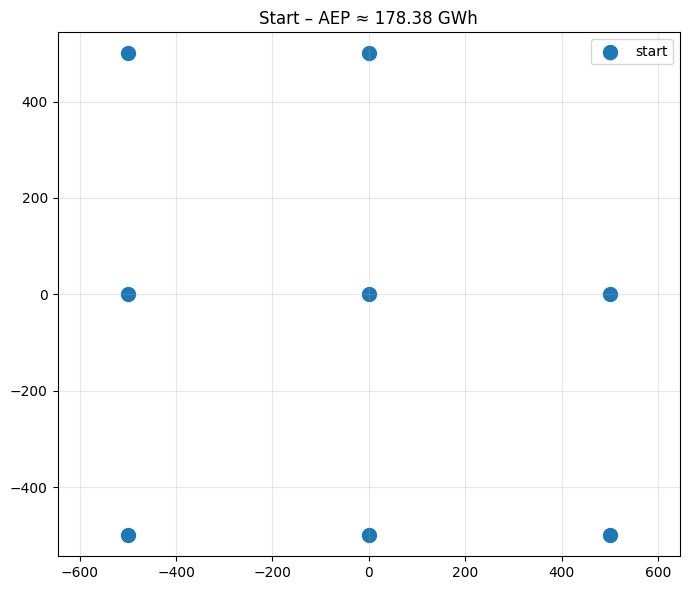

NameError: name 'AEP_opt' is not defined

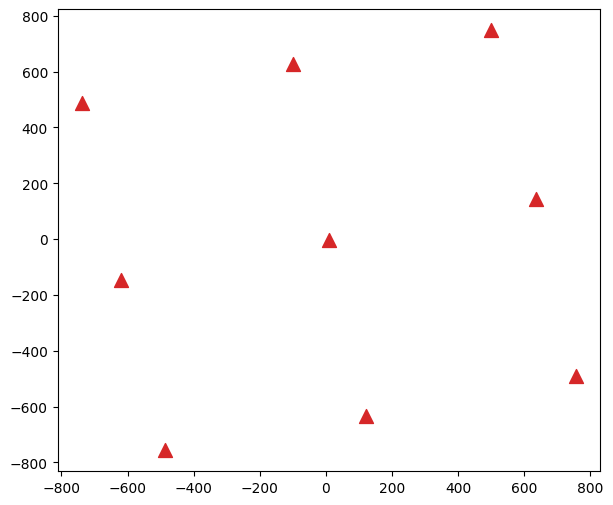

In [38]:
plt.figure(figsize=(7,6))
plt.scatter(x_init, y_init, c='C0', s=100, label='start')
plt.title(f"Start – AEP ≈ {AEP_init:.2f} GWh")
plt.axis('equal')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("results/figures/iea37_start.png", dpi=150, bbox_inches='tight')
plt.show()

plt.figure(figsize=(7,6))
plt.scatter(state['x'], state['y'], c='C3', s=100, marker='^', label='opt')
plt.title(f"Optymalny – AEP {AEP_opt:.2f} GWh")
plt.axis('equal')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("results/figures/iea37_opt.png", dpi=150, bbox_inches='tight')
plt.show()

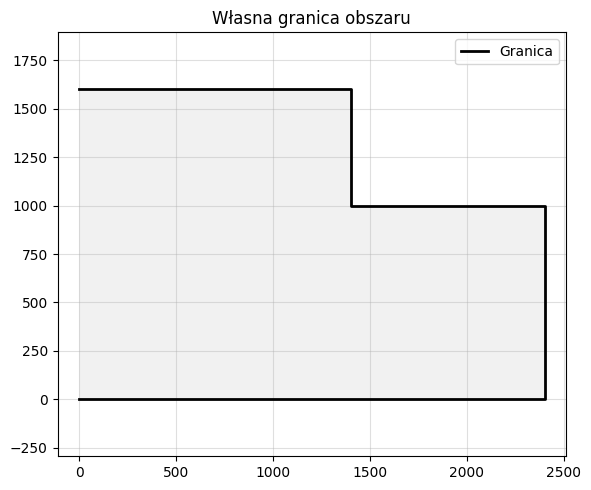

In [39]:
#%% [markdown]
## Sprint 2 – Własna granica + testy minimalnej odległości

D = 130.0  # średnica wirnika [m]

# Prosta, ale ciekawa granica – prostokąt z wcięciem (w metrach)
boundary_custom = np.array([
    [   0,    0],
    [2400,    0],
    [2400, 1000],
    [1400, 1000],
    [1400, 1600],
    [   0, 1600]
])

# Wizualizacja samej granicy
plt.figure(figsize=(6, 5))
plt.plot(boundary_custom[:,0], boundary_custom[:,1], 'k-', linewidth=2, label='Granica')
plt.fill(boundary_custom[:,0], boundary_custom[:,1], 'lightgray', alpha=0.3)
plt.title("Własna granica obszaru")
plt.axis('equal')
plt.grid(True, alpha=0.4)
plt.legend()
plt.tight_layout()
plt.savefig("results/figures/custom_boundary.png", dpi=140, bbox_inches='tight')
plt.show()

# Jitter startowy – zapobiega nakładaniu turbin
np.random.seed(42)  # powtarzalność
jitter_m = 40.0     # 40 metrów – wystarczająco dużo, żeby uniknąć crashu
x_jitter = x_init + np.random.normal(0, jitter_m, n_wt)
y_jitter = y_init + np.random.normal(0, jitter_m, n_wt)


In [61]:
print("=== NAJBEZPIECZNIEJSZY TEST – 9 TURBIN, TYLKO GRANICA ===")

constraints = [XYBoundaryConstraint(boundary_custom, 'polygon')]

tf_safe = TopFarmProblem(
    design_vars = {'x': x_init.copy(), 'y': y_init.copy()},   # pełny układ 9 turbin
    cost_comp = cost_comp,
    constraints = constraints,
    driver = EasyScipyOptimizeDriver(optimizer='SLSQP', maxiter=50, disp=False),
    plot_comp = NoPlot()
)

print("Setup przeszedł – teraz evaluate...")
tf_safe.evaluate()
AEP_start_safe = tf_safe['AEP'][0]
print("AEP start (tylko granica):", AEP_start_safe)

print("Uruchamiam optymalizację – maxiter=50 żeby szybko...")
_, state_safe, _ = tf_safe.optimize()
AEP_end_safe = state_safe['AEP'][0]

print("AEP po optymalizacji:", AEP_end_safe)
print("Poprawa:", round((AEP_end_safe / AEP_start_safe - 1)*100, 1), "%")

# Wykres
plt.figure(figsize=(8, 6))
plt.scatter(state_safe['x'], state_safe['y'], c='blue', s=100, marker='o')
plt.plot(boundary_custom[:,0], boundary_custom[:,1], 'r--', lw=2, label='granica')
plt.title("Layout po optymalizacji – tylko granica")
plt.axis('equal')
plt.grid(True)
plt.legend()
plt.savefig("results/figures/safe_boundary_only.png", dpi=150, bbox_inches='tight')
plt.show()

=== NAJBEZPIECZNIEJSZY TEST – 9 TURBIN, TYLKO GRANICA ===
Setup przeszedł – teraz evaluate...
AEP start (tylko granica): 0.0
Uruchamiam optymalizację – maxiter=50 żeby szybko...


ValueError: 'cost_comp' <class PyWakeAEPCostModelComponent>: Error calling compute_partials(), Turbines 0 and 1 are at the same position
Turbines 0 and 3 are at the same position
Turbines 0 and 4 are at the same position
Turbines 1 and 0 are at the same position
Turbines 1 and 3 are at the same position
Turbines 1 and 4 are at the same position
Turbines 2 and 5 are at the same position
Turbines 3 and 0 are at the same position
Turbines 3 and 1 are at the same position
Turbines 3 and 4 are at the same position
Turbines 4 and 0 are at the same position
Turbines 4 and 1 are at the same position
Turbines 4 and 3 are at the same position
Turbines 5 and 2 are at the same position
Turbines 6 and 7 are at the same position
Turbines 7 and 6 are at the same position